# Úkol č. 2 - předzpracování dat a binární klasifikace (do 10. listopadu)

  * Cílem thoto úkolu je vyzkoušet si naučit prediktivní model pro binární klasifikaci.
  * Budete se muset vypořádat s příznaky, které jsou různých typů a které bude třeba nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na trénovací, testovací a případně i validační množinu (preferujeme ale použití cross-validation).
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací/vaidační množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí testovací množiny. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor(y) s predikcemi pro vyhodnocovací data.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. **První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

In [1]:
### odtud už je to Vaše
import math
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, ParameterGrid
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Pomocné funkce - aby se furt neopakoval kód

In [2]:
def RandomForestClass(Xdata, ydata):
    rd_seed = 666
    Xtrain, Xval, ytrain, yval = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed)
    param_grid = {
        'n_estimators': range(1,20,1),
        'max_depth': range(1, 12, 2),
        'criterion': ['entropy', 'gini'],
    }
    param_comb = ParameterGrid(param_grid)
    print(f"Number of param comb: {len(param_comb)}")
    val_acc = []
    for params in param_comb:
        dt = RandomForestClassifier(**params, random_state=333, n_jobs=-1, warm_start=True, bootstrap=True)
        dt.fit(Xtrain, ytrain)
        val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))
    best_params = param_comb[np.argmax(val_acc)]
    print(best_params)
    dt = RandomForestClassifier(**best_params, random_state=333)
    dt.fit(Xtrain, ytrain)
    print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
    print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
    return dt

def DecisionTreeClass(Xdata, ydata):
    rd_seed = 666
    Xtrain, Xval, ytrain, yval = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed)
    val_acc = []
    train_acc = []
    for depth in range(1,20):
        dt = DecisionTreeClassifier(max_depth=depth, random_state=333)
        dt.fit(Xtrain, ytrain)
        train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
        val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))
    optimal_depth = np.argmax(val_acc) + 1
    print('optimal depth is', optimal_depth)
    dt = DecisionTreeClassifier(max_depth=optimal_depth, random_state=333)
    dt.fit(Xtrain, ytrain)
    print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
    print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
    plt.figure(figsize=(20,6))
    plt.plot(range(1,20), train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
    plt.plot(range(1,20), val_acc,'ob-')
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend(['train', 'validation'])
    plt.show()
    return dt

def AdaBoostClass(Xdata, ydata):
    rd_seed = 666
    Xtrain, Xval, ytrain, yval = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed)
    param_grid = {
        'n_estimators': range(1,60,3),
        'learning_rate': [.05, .1,.2,  .3, .5, .7,],
    }
    param_comb = ParameterGrid(param_grid)
    val_acc = []
    print(f"Number of param comb: {len(param_comb)}")
    for params in param_comb:
        dt = AdaBoostClassifier(**params, random_state=333)
        dt.fit(Xtrain, ytrain)
        val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))
    best_params = param_comb[np.argmax(val_acc)]
    print(best_params)
    dt = AdaBoostClassifier(**best_params, random_state=333)
    dt.fit(Xtrain, ytrain)
    print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
    print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
    return dt

def DecisionTreeRegre(xage, yage):
    rd_seed = 666
    Xage_train, Xage_val, yage_train, yage_val = train_test_split(xage, yage, test_size=0.25, random_state=rd_seed)
    val_acc = []
    train_acc = []
    for depth in range(1,20):
        dt = DecisionTreeRegressor(max_depth=depth, random_state=333)
        dt.fit(Xage_train, yage_train)
        train_acc.append(math.sqrt(metrics.mean_squared_error(yage_train, dt.predict(Xage_train))))
        val_acc.append(math.sqrt(metrics.mean_squared_error(yage_val, dt.predict(Xage_val))))
    optimal_depth = np.argmin(val_acc) + 1
    print('optimal depth is', optimal_depth)
    dt = DecisionTreeRegressor(max_depth=optimal_depth, random_state=333)
    dt.fit(Xage_train, yage_train)
    print('accuracy score (train): {0:.6f}'.format(math.sqrt(metrics.mean_squared_error(yage_train, dt.predict(Xage_train)))))
    print('accuracy score (validation): {0:.6f}'.format(math.sqrt(metrics.mean_squared_error(yage_val, dt.predict(Xage_val)))))
    plt.figure(figsize=(20,6))
    plt.plot(range(1,20), train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
    plt.plot(range(1,20), val_acc,'ob-')
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend(['train', 'validation'])
    plt.show()
    return dt

def RandomForestRegre(xage, yage):
    rd_seed = 666
    Xage_train, Xage_val, yage_train, yage_val = train_test_split(xage, yage, test_size=0.25, random_state=rd_seed)
    param_grid = {
        'n_estimators': range(1,40,3),
        'max_depth': range(1, 8),
    }
    param_comb = ParameterGrid(param_grid)
    print(len(param_comb))
    val_acc = []
    for params in param_comb:
        dt = RandomForestRegressor(**params, random_state=333, n_jobs=-1, warm_start=True, bootstrap=True)
        dt.fit(Xage_train, yage_train)
        val_acc.append(math.sqrt(metrics.mean_squared_error(yage_val, dt.predict(Xage_val))))
    best_params = param_comb[np.argmin(val_acc)]
    print(best_params)
    dt = RandomForestRegressor(**best_params, random_state=333)
    dt.fit(Xage_train, yage_train)
    print('accuracy score (train): {0:.6f}'.format(math.sqrt(metrics.mean_squared_error(yage_train, dt.predict(Xage_train)))))
    print('accuracy score (validation): {0:.6f}'.format(math.sqrt(metrics.mean_squared_error(yage_val, dt.predict(Xage_val)))))
    print(max(val_acc))
    print(min(val_acc))
    return dt

### Načtení dat a replace ? na nan, aby fungovaly not filled metody pandas

In [3]:
data = pd.read_csv('data.csv')
evaluation = pd.read_csv('evaluation.csv')
data = data.replace('?', np.nan)

### Rozdělení na vysvětlovanou proměnnou a data
    Bylo dropnuto home.dest protože to nevypadalo jako field, který by toho hodně ovlivnil

In [4]:
ydata = data.iloc[:,1]
Xdata = data.iloc[:,2:-1]
# droping home.dest, since it does not seem to matter

### Změna kabiny na číslo. U lidí bez kabiny předpokládáno, že neměli vlastní kajutu, a dostali nejhorší rating

In [5]:
Xdata["cabin"] = Xdata["cabin"].apply(lambda x: ord(x[0])-65 if isinstance(x, str) else ord("H")-65)

### Doplnění věku - průměrem

In [6]:
Xdata["age"] = Xdata["age"].apply(lambda x: Xdata["age"].mean() if math.isnan(x) else x)

### Doplnění chybějících údajů o ceně vstupenky - průměr z nejnižší cenové kategorie
    Předpokládáno že u všech bohatých lidí byla evidence pořádná. Navíc data jsou nakloněná na pravou stranu, tak chceme    spíš něco z té strany

In [7]:
Xdata["fare"] = Xdata["fare"].apply(lambda x: Xdata[Xdata["cabin"]==ord("H")-65]["fare"].mean() if math.isnan(x) else x)

### One hot encoding na místo nástupu
    Tento sloupec by se taky dal pustit, protože by neměl ovlivňovat výsledky

In [8]:
Xdata["embarked"] = Xdata["embarked"].apply(lambda x: x if isinstance(x, str) else "Q")
Xdata["S"] = Xdata["embarked"].apply(lambda x: 1 if x=="S" else 0)
Xdata["Q"] = Xdata["embarked"].apply(lambda x: 1 if x=="Q" else 0)
Xdata["C"] = Xdata["embarked"].apply(lambda x: 1 if x=="C" else 0)
Xdata = Xdata.drop("embarked", axis=1)


### Binarní flag - rozdělení na 1 a 0

In [9]:
Xdata["sex"] = Xdata["sex"].apply(lambda x: 1 if x=="female" else 0)

In [10]:
Xdata[Xdata.isna().any(axis=1)]
# no missing data, we can try to fit model

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,S,Q,C


### Dropnutí jména a ID ticketu - nepodstatné fieldy

In [11]:
Xdata.drop(["name", "ticket"], axis=1, inplace=True)

In [12]:
Xdata

,pclass,sex,age,sibsp,parch,fare,cabin,S,Q,C
0,3,1,22.00000,0,0,7.7500,7,1,0,0
1,3,0,29.82718,0,0,8.4583,7,0,1,0
2,1,1,19.00000,1,0,91.0792,1,0,0,1
3,3,0,25.00000,0,0,7.2250,7,0,0,1
4,3,0,29.82718,0,0,7.7500,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...
995,1,1,48.00000,1,1,79.2000,1,0,0,1
996,2,1,3.00000,1,2,41.5792,7,0,0,1
997,3,1,29.82718,0,0,7.7500,7,0,1,0
998,3,0,29.82718,0,0,7.7500,7,0,1,0


### Split dat. Bylo použito trénovací a validační množiny
Testovací data máme predikovat, takže mi přišlo zbytečný to rozdělovat na 3 množiny, když mi stačí 2, protože té testovací bych se stejně nedotkl

In [13]:
rd_seed = 666
Xtrain, Xval, ytrain, yval = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed)

## Rozhodovací strom
Má často problémy s přeučením, nicméně výsledky porovnatelné s ostatnímy

optimal depth is 3
accuracy score (train): 0.830667
accuracy score (validation): 0.804000


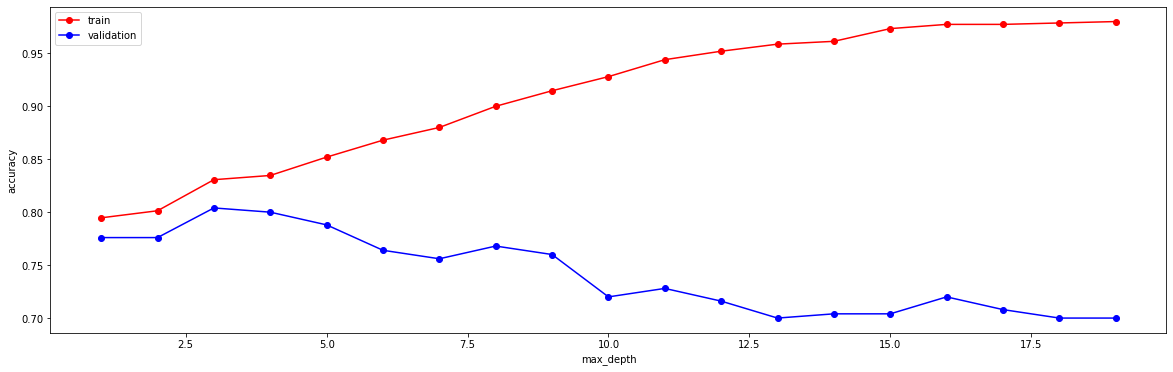

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=333, splitter='best')

In [14]:
DecisionTreeClass(Xdata, ydata)

## Náhodný strom
Kdybych nedělal i druhý bonus, použiji tento model
Má největší přesnost na validační množině a výsledky na testu by mohly být velice uspokojivé

In [15]:
RandomForestClass(Xdata, ydata)

Number of param comb: 228
{'n_estimators': 17, 'max_depth': 7, 'criterion': 'entropy'}
accuracy score (train): 0.897333
accuracy score (validation): 0.812000


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=17,
                       n_jobs=None, oob_score=False, random_state=333,
                       verbose=0, warm_start=False)

## Adaboost. Vyzkoušeno víc parametrů, nicméně nebyl lepší nežli náhodný les

In [16]:
AdaBoostClass(Xdata, ydata)

Number of param comb: 120
{'n_estimators': 22, 'learning_rate': 0.5}
accuracy score (train): 0.814667
accuracy score (validation): 0.808000


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=22, random_state=333)

## Jiný způsob doplnění dat
### Naučení stromu na věk a následná predikce

In [17]:
data = pd.read_csv('data.csv')
evaluation = pd.read_csv('evaluation.csv')
data = data.replace('?', np.nan)
data = data.iloc[:, 1:]
data["cabin"] = data["cabin"].apply(lambda x: ord(x[0])-65 if isinstance(x, str) else ord("H")-65)
data["fare"] = data["fare"].apply(lambda x: data[data["cabin"]==ord("H")-65]["fare"].mean() if math.isnan(x) else x)
data["embarked"] = data["embarked"].apply(lambda x: x if isinstance(x, str) else "Q")
data["S"] = data["embarked"].apply(lambda x: 1 if x=="S" else 0)
data["Q"] = data["embarked"].apply(lambda x: 1 if x=="Q" else 0)
data["C"] = data["embarked"].apply(lambda x: 1 if x=="C" else 0)
data = data.drop("embarked", axis=1)
data["sex"] = data["sex"].apply(lambda x: 1 if x=="female" else 0)
data.drop(["home.dest", "ticket", "name"], axis=1, inplace=True)

age_present = data[data.iloc[:, 3].notna()]
yage = age_present.iloc[:, 3]
xage = age_present.drop(["age",], axis=1)
xage = xage.drop(["survived"], axis=1)

optimal depth is 5
accuracy score (train): 11.322089
accuracy score (validation): 12.150339


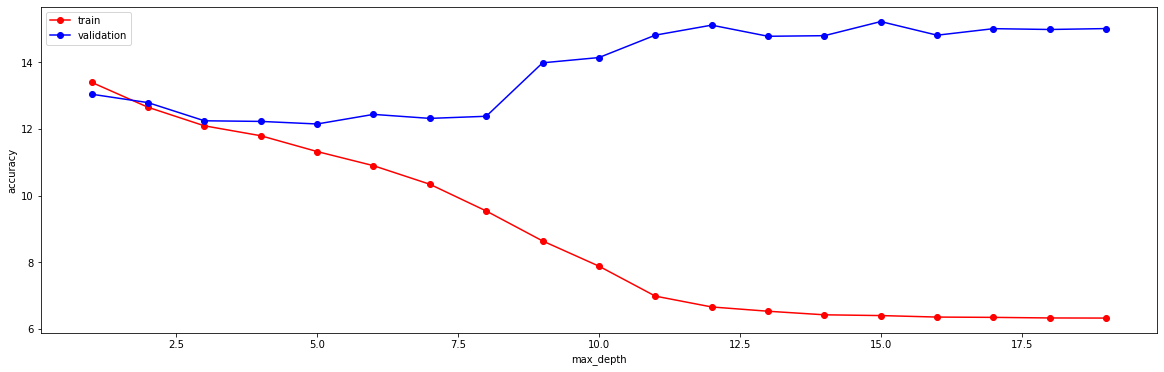

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=333, splitter='best')

In [18]:
DecisionTreeRegre(xage, yage)

In [19]:
dt_fill_age = RandomForestRegre(xage, yage)

91
{'n_estimators': 25, 'max_depth': 7}
accuracy score (train): 9.689131
accuracy score (validation): 11.760516
13.54523598332908
11.76051629769573


In [20]:
no_age = data[data.iloc[:, 3].isna()]
no_age_survived = data.iloc[:, 0]
no_age = no_age.drop(["age", "survived"], axis=1)
no_age["age"] = dt_fill_age.predict(no_age)
no_age["survived"] = no_age_survived
no_age["age"].mean()

29.964568515257568

In [21]:
all_data = pd.concat([no_age, age_present], sort=False)
all_data

,pclass,sex,sibsp,parch,fare,cabin,S,Q,C,age,survived
1,3,0,0,0,8.4583,7,0,1,0,32.086709,0
4,3,0,0,0,7.7500,7,0,1,0,37.024884,0
7,3,1,1,0,16.1000,7,1,0,0,31.909621,1
30,3,1,1,1,22.3583,5,0,0,1,15.981051,1
31,3,0,0,0,7.2500,7,1,0,0,28.718256,0
...,...,...,...,...,...,...,...,...,...,...,...
992,1,0,0,0,30.0000,3,1,0,0,29.000000,0
993,1,0,1,0,82.2667,1,1,0,0,24.000000,1
995,1,1,1,1,79.2000,1,0,0,1,48.000000,1
996,2,1,1,2,41.5792,7,0,0,1,3.000000,1


In [22]:
ydata_age_filled = all_data.iloc[:,-1]
Xdata_age_filled = all_data.iloc[:,:-1]

### Věk doplněn, můžeme se kouknout na predikci

optimal depth is 3
accuracy score (train): 0.800000
accuracy score (validation): 0.812000


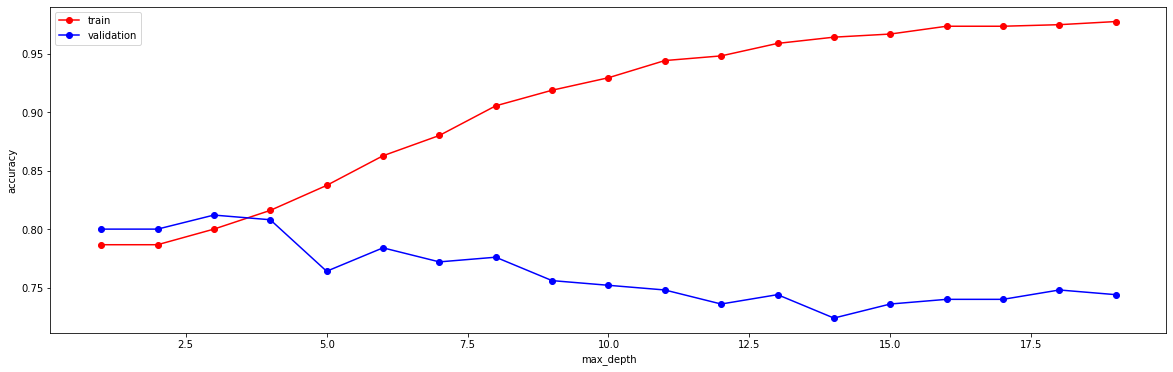

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=333, splitter='best')

In [23]:
DecisionTreeClass(Xdata_age_filled, ydata_age_filled)

### Zatím nejlepší model. Uložím si ho do proměnné, protože vypadá slibně
Restart and run all poznámka - nejsem si jist, co jsem změnil, každopádně jsem dostával 84% úspěšnost. Bohužel se mi už nepodařilo vypátrat čím to bylo. Každopádně tato forma predikce zůstala pro evaluační množinu

In [24]:
dt_predict = RandomForestClass(Xdata_age_filled, ydata_age_filled)

Number of param comb: 228
{'n_estimators': 13, 'max_depth': 5, 'criterion': 'entropy'}
accuracy score (train): 0.838667
accuracy score (validation): 0.812000


In [25]:
data = pd.read_csv('data.csv')
evaluation = pd.read_csv('evaluation.csv')
data = data.replace('?', np.nan)
data = data.iloc[:, 1:]
data["cabin"] = data["cabin"].apply(lambda x: ord(x[0])-65 if isinstance(x, str) else ord("H")-65)
data["fare"] = data["fare"].apply(lambda x: data[data["cabin"]==ord("H")-65]["fare"].mean() if math.isnan(x) else x)
data["embarked"] = data["embarked"].apply(lambda x: x if isinstance(x, str) else "Q")
data["S"] = data["embarked"].apply(lambda x: 1 if x=="S" else 0)
data["Q"] = data["embarked"].apply(lambda x: 1 if x=="Q" else 0)
data["C"] = data["embarked"].apply(lambda x: 1 if x=="C" else 0)
data = data.drop("embarked", axis=1)
data["sex"] = data["sex"].apply(lambda x: 1 if x=="female" else 0)
data.drop(["home.dest", "ticket", "name"], axis=1, inplace=True)
data

,survived,pclass,sex,age,sibsp,parch,fare,cabin,S,Q,C
0,1,3,1,22.0,0,0,7.7500,7,1,0,0
1,0,3,0,NaN,0,0,8.4583,7,0,1,0
2,1,1,1,19.0,1,0,91.0792,1,0,0,1
3,0,3,0,25.0,0,0,7.2250,7,0,0,1
4,0,3,0,NaN,0,0,7.7500,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,1,48.0,1,1,79.2000,1,0,0,1
996,1,2,1,3.0,1,2,41.5792,7,0,0,1
997,1,3,1,NaN,0,0,7.7500,7,0,1,0
998,1,3,0,NaN,0,0,7.7500,7,0,1,0


### Doplnění dat KNR

In [26]:
def replace_nans(df, cols_nan, params):
    ### your code goes here
   
    for col in cols_nan:
        
        missing = df[df[col].isnull()]  #D1
        filled  = df[df[col].notnull()] #D2
        
        #X nechceme chybějící hodnoty a Id nijak nepomáhá v predikci        
        missingX = missing.drop(columns=cols_nan,) #X2
        filledX  = filled.drop(columns=cols_nan,) #X
        filledY  = filled[col] #Y
               
        # použití modelu a rozbalení parametrů
        model = KNeighborsRegressor(**params)
        model.fit(filledX, filledY)        
        missingY = model.predict(missingX)
        
        #vložíme predikované hodnoty              
        df[col][df[col].isnull()] = missingY        
        
    return df, model

In [27]:
params = {
        'n_neighbors': 6
}
data, modelKNN = replace_nans(data, ["age"], params)
data[data.isna().any(axis=1)]

/mnt/c/Users/OndrejChladek/Documents/Skola/VZD/venv/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,survived,pclass,sex,age,sibsp,parch,fare,cabin,S,Q,C


In [28]:
ydata = data.iloc[:, 0]
xdata = data.iloc[:, 1:]
xdata

,pclass,sex,age,sibsp,parch,fare,cabin,S,Q,C
0,3,1,22.000000,0,0,7.7500,7,1,0,0
1,3,0,41.500000,0,0,8.4583,7,0,1,0
2,1,1,19.000000,1,0,91.0792,1,0,0,1
3,3,0,25.000000,0,0,7.2250,7,0,0,1
4,3,0,42.333333,0,0,7.7500,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...
995,1,1,48.000000,1,1,79.2000,1,0,0,1
996,2,1,3.000000,1,2,41.5792,7,0,0,1
997,3,1,19.166667,0,0,7.7500,7,0,1,0
998,3,0,32.083333,0,0,7.7500,7,0,1,0


optimal depth is 3
accuracy score (train): 0.830667
accuracy score (validation): 0.804000


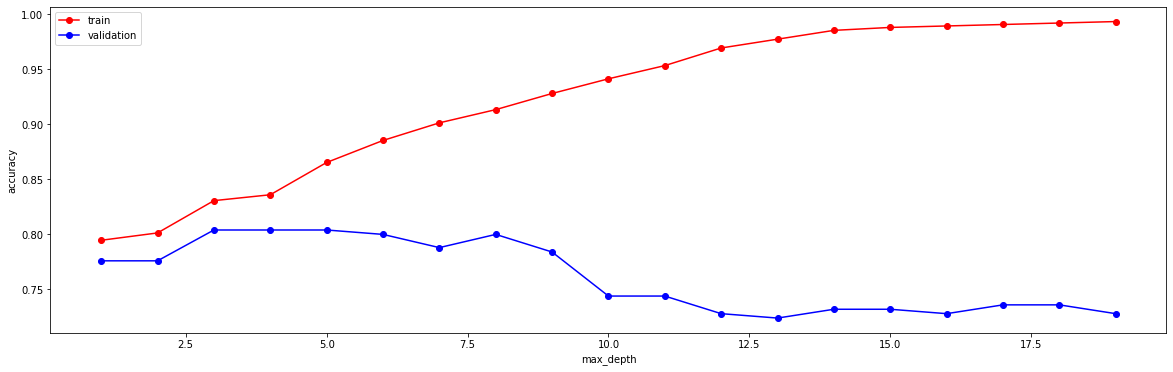

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=333, splitter='best')

In [29]:
DecisionTreeClass(xdata, ydata)

In [30]:
RandomForestClass(xdata, ydata)

Number of param comb: 228
{'n_estimators': 16, 'max_depth': 5, 'criterion': 'gini'}
accuracy score (train): 0.857333
accuracy score (validation): 0.816000


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=333,
                       verbose=0, warm_start=False)

In [31]:
AdaBoostClass(xdata, ydata)

Number of param comb: 120
{'n_estimators': 58, 'learning_rate': 0.3}
accuracy score (train): 0.818667
accuracy score (validation): 0.800000


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.3,
                   n_estimators=58, random_state=333)

### Vidíme že doplnění věku KNR algoritmem nevyprodukovalo lepší výsledky na validační množině než doplnění náhodným lesem
Jinak - maximum se nezměnilo ani jedním algoritmem. Proto pro predikci použiji na doplnění věku náhodný les a na predikci taktéž. Zbylé parametry budu upravovat stejně.

In [32]:
evaluation = pd.read_csv('evaluation.csv')
evaluation = evaluation.replace('?', np.nan)
evaluation = evaluation.iloc[:, 1:]
evaluation["cabin"] = evaluation["cabin"].apply(lambda x: ord(x[0])-65 if isinstance(x, str) else ord("H")-65)
evaluation["fare"] = evaluation["fare"].apply(lambda x: evaluation[evaluation["cabin"]==ord("H")-65]["fare"].mean() if math.isnan(x) else x)
evaluation["embarked"] = evaluation["embarked"].apply(lambda x: x if isinstance(x, str) else "Q")
evaluation["S"] = evaluation["embarked"].apply(lambda x: 1 if x=="S" else 0)
evaluation["Q"] = evaluation["embarked"].apply(lambda x: 1 if x=="Q" else 0)
evaluation["C"] = evaluation["embarked"].apply(lambda x: 1 if x=="C" else 0)
evaluation = evaluation.drop("embarked", axis=1)
evaluation["sex"] = evaluation["sex"].apply(lambda x: 1 if x=="female" else 0)
evaluation.drop(["home.dest", "ticket", "name"], axis=1, inplace=True)


### Věk nakonec doplněn náhodným lesem

In [33]:
evaluation["age"] = dt_fill_age.predict(evaluation.drop(["age"], axis=1))
evaluation

,pclass,sex,age,sibsp,parch,fare,cabin,S,Q,C
0,1,0,22.072821,2,2,262.3750,1,0,0,1
1,3,0,27.849089,0,0,7.4958,7,1,0,0
2,3,0,37.024884,0,0,7.7500,7,0,1,0
3,3,0,28.354118,0,0,7.2250,7,0,0,1
4,3,0,27.061371,0,0,9.5000,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...
304,1,0,46.255843,0,0,30.5000,1,0,0,1
305,2,0,29.821196,0,0,10.5000,7,1,0,0
306,3,0,27.849089,0,0,7.5500,7,1,0,0
307,3,1,23.655028,0,2,24.1500,7,1,0,0


### Používám model náhodného lesu naučeného na doplněných datech náhodným lesem

In [34]:
evaluation["survived"] = dt_predict.predict(evaluation)
evaluation

,pclass,sex,age,sibsp,parch,fare,cabin,S,Q,C,survived
0,1,0,22.072821,2,2,262.3750,1,0,0,1,0
1,3,0,27.849089,0,0,7.4958,7,1,0,0,0
2,3,0,37.024884,0,0,7.7500,7,0,1,0,0
3,3,0,28.354118,0,0,7.2250,7,0,0,1,0
4,3,0,27.061371,0,0,9.5000,7,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
304,1,0,46.255843,0,0,30.5000,1,0,0,1,0
305,2,0,29.821196,0,0,10.5000,7,1,0,0,0
306,3,0,27.849089,0,0,7.5500,7,1,0,0,0
307,3,1,23.655028,0,2,24.1500,7,1,0,0,1


In [35]:
evaluation.to_csv('evaluated.csv')